In [1]:
from utils import *

### Model and Reward function

In [2]:
class LSTMModel_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

        # self.sigmoid  = nn.Sigmoid()

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)

        # out = self.sigmoid(out)

        return out
    
    
def Reward(outputs, price):
    reward = outputs * price
    return reward

### Creating model, loading weights and data

In [3]:
model = LSTMModel_1(78, 512, 5, 1).to(device=DEVICE).eval()
model.load_state_dict(
    torch.load("./models/lstm_training_04_09_2023.pth")
);

In [4]:
data_X = torch.split(
    torch.load("data/X_test_lstm_decade_price_01_09.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)
data_x = torch.split(
    torch.load("data/x_test_lstm_decade_price_01_09.pt").to(torch.float32), 1
)

### Manual optimization step

In [5]:
qids = np.array([9860, 9673, 9855, 9333])
price_mean, price_std = (21.230517726667767, 13.387471717906585)
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 100, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

### Ploting the results

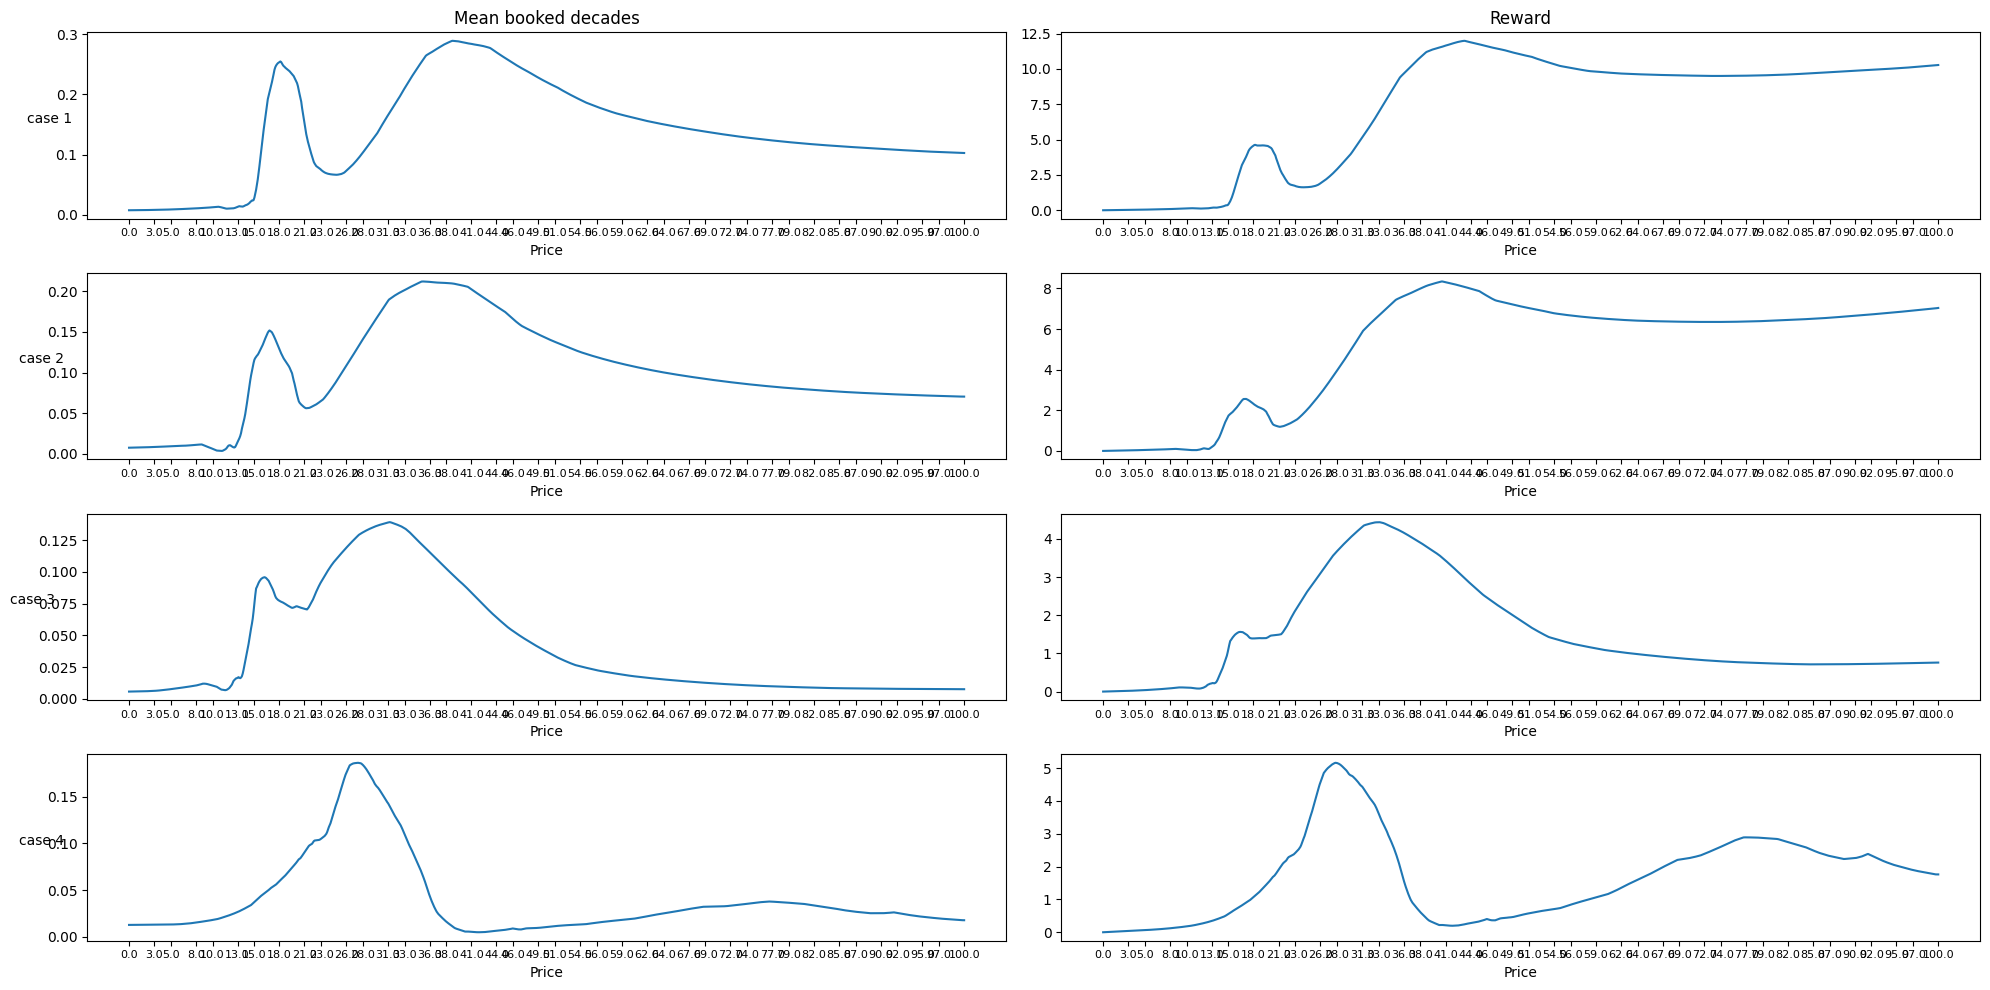

In [6]:
lbl = np.round(np.linspace(0, 100, 40), 0)
fig, ax = plt.subplots(M, 2, figsize=(20, 10))
from matplotlib.ticker import MaxNLocator

for i in range(M):
    ax[i, 0].plot(history[i, 0, :], history[i, 1, :])
    ax[i, 1].plot(history[i, 0, :], history[i, 2, :])

for ax_, col in zip(ax[0], ["Mean booked decades", "Reward"]):
    ax_.set_title(col)

for i in range(M):
    ylabel = ax[i, 0].set_ylabel(f"case {i+1}")
    ylabel.set_rotation(0)

    ax[i, 0].set_xlabel(f"Price")
    ax[i, 1].set_xlabel(f"Price")

    ax[i, 0].set_xticks(lbl)
    ax[i, 0].set_xticklabels(lbl)
    ax[i, 1].set_xticks(lbl)
    ax[i, 1].set_xticklabels(lbl)

    ax[i, 0].tick_params(axis="x", labelsize=8)
    ax[i, 1].tick_params(axis="x", labelsize=8)


plt.tight_layout()

### Optimization step for neighboours and qids

In [7]:
data_X = torch.split(
    torch.load("data/X_test_lstm_decade_price_04_09.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)
data_x = torch.split(
    torch.load("data/x_test_lstm_decade_price_04_09.pt").to(torch.float32), 1
)

In [9]:
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 100, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

In [24]:
test_qids = [9333.,   9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
             9404.,   9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
             9642.,   9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
             9858.,   9859.,   9932.,   9933., 785704., 931305., 931326.,
             9855.,   9948.,  20457.,  20472.,  20594.,  20595.,  20643.,
             20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
             26396., 327508., 327509., 344212., 814900., 840435., 842866.,
             887322., 931310., 931324.,   9860.,   9672.,   9673.,   9674.]

test_qids.sort()

neighbourhood = {9333 : np.array([9333., 9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
                                  9404., 9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
                                  9642., 9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
                                  9858., 9859.,   9932.,   9933.,   785704., 931305., 931326.]),
              
               9855 : np.array([9855,    9948.,   20457.,  20472.,  20594.,  20595.,  20643.,
                                20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
                                26396.,  327508., 327509., 344212., 814900., 840435., 842866.,
                                887322., 931310., 931324.]),
               
               9673 : np.array([9673, 9672., 9674.]),
               
               
               9860 : np.array([9860.])
              }

data = pd.read_pickle("./data/decade_price_data_combined_01_09.pkl")
data = data[data.GJ == 2023]
data.sort_values(by="Qid", inplace=True)

qid_9333_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis", "Max_optimal_preis"])
qid_9855_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis", "Max_optimal_preis"])
qid_9673_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis", "Max_optimal_preis"])
qid_9860_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis", "Max_optimal_preis"])

qid_9333_data["Qid"] = sorted(neighbourhood[9333])
qid_9855_data["Qid"] = sorted(neighbourhood[9855])
qid_9673_data["Qid"] = sorted(neighbourhood[9673])
qid_9860_data["Qid"] = sorted(neighbourhood[9860])

qid_9333_data["Preis"] = data[data.Qid.isin(neighbourhood[9333])].Preis.values
qid_9855_data["Preis"] = data[data.Qid.isin(neighbourhood[9855])].Preis.values
qid_9673_data["Preis"] = data[data.Qid.isin(neighbourhood[9673])].Preis.values
qid_9860_data["Preis"] = data[data.Qid.isin(neighbourhood[9860])].Preis.values

new_history = {}
new_history_plot = {}

def find_nearest(array, value, idxis=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idxis:
        return idx
    return array[idx]
 
for k, qid in enumerate(test_qids):
    peak_ids = scipy.signal.find_peaks(history[k, 2])[0]
    prices = history[k, 0, peak_ids]
    optim_price = find_nearest(prices, data[data.Qid == qid].Preis.values)
    margin = optim_price * 0.05
    new_history[qid] = [optim_price-margin, optim_price, optim_price+margin]
    ids = find_nearest(optim_price, data[data.Qid == qid].Preis.values, True)  
    
    new_history_plot[qid] = peak_ids[ids]

### Plot of reward func and optimal price range

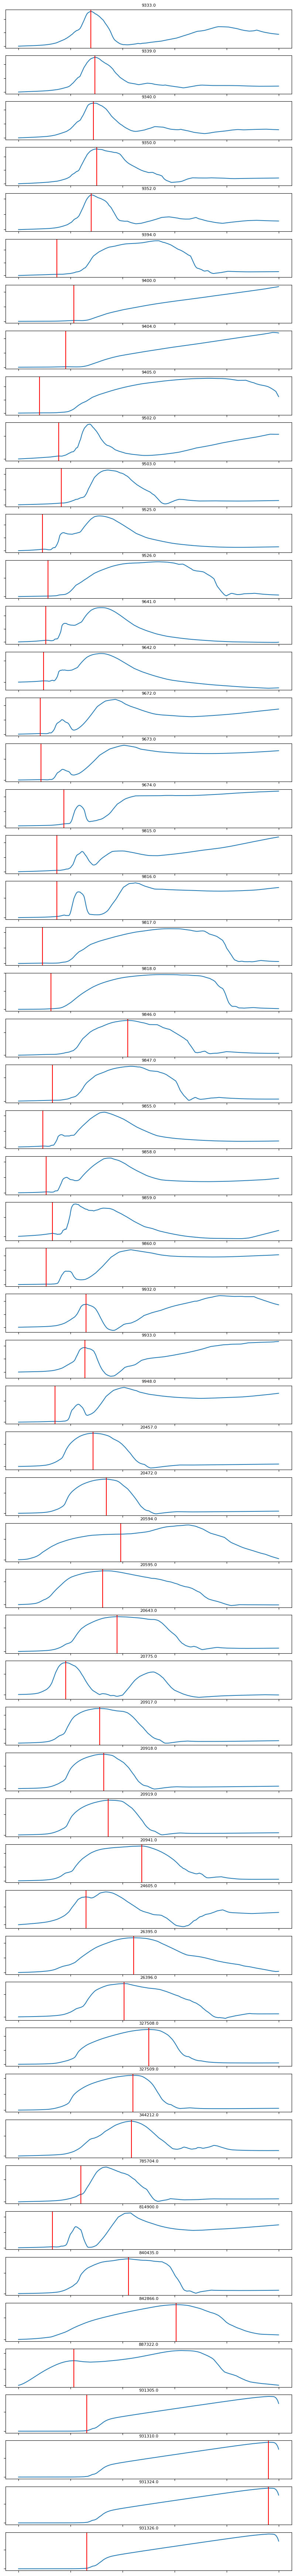

In [39]:
fig, ax = plt.subplots(history.shape[0], figsize=(10, 90))
    
for j in range(history.shape[0]):
    ax[j].plot(history[j, -1, :])
    ax[j].axvline(list(new_history_plot.values())[j], color="red")
    ax[j].set_title(list(new_history_plot.keys())[j], fontsize=8)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])

### Prepairing and saving optimal price with different sheets based on 4 qids

In [44]:
for j, qid in enumerate(neighbourhood[9333]):
    qid_9333_data.iloc[j, 2] = new_history[qid][1]
    qid_9333_data.iloc[j, 3] = new_history[qid][0]
    qid_9333_data.iloc[j, 4] = new_history[qid][2]
    
for j, qid in enumerate(neighbourhood[9855]):
    qid_9855_data.iloc[j, 2] = new_history[qid][1]
    qid_9855_data.iloc[j, 3] = new_history[qid][0]
    qid_9855_data.iloc[j, 4] = new_history[qid][2]
    
for j, qid in enumerate(neighbourhood[9673]):
    qid_9673_data.iloc[j, 2] = new_history[qid][1]
    qid_9673_data.iloc[j, 3] = new_history[qid][0]
    qid_9673_data.iloc[j, 4] = new_history[qid][2]
    
for j, qid in enumerate(neighbourhood[9860]):
    qid_9860_data.iloc[j, 2] = new_history[qid][1]
    qid_9860_data.iloc[j, 3] = new_history[qid][0]
    qid_9860_data.iloc[j, 4] = new_history[qid][2]

In [45]:
with pd.ExcelWriter('optimal_preis.xlsx') as writer:
    qid_9333_data.to_excel(writer, sheet_name='9333', index=False)
    qid_9855_data.to_excel(writer, sheet_name='9855', index=False)
    qid_9673_data.to_excel(writer, sheet_name='9673', index=False)    
    qid_9860_data.to_excel(writer, sheet_name='9860', index=False)    

In [46]:
qid_9333_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,9333.0,28.6,27.827828,26.436436,29.219219
1,9339.0,28.6,29.429429,27.957958,30.900901
2,9340.0,28.6,28.828829,27.387387,30.27027
3,9350.0,31.1,30.03003,28.528529,31.531532
4,9352.0,28.6,27.927928,26.531532,29.324324
5,9394.0,49.7,53.453453,50.780781,56.126126
6,9400.0,75.5,22.922923,21.776777,24.069069
7,9404.0,74.0,97.697698,92.812813,102.582583
8,9405.0,71.5,72.672673,69.039039,76.306306
9,9502.0,25.4,27.327327,25.960961,28.693694


In [47]:
qid_9855_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,9855.0,18.00,18.618619,17.687688,19.54955
1,9948.0,21.90,22.922923,21.776777,24.069069
2,20457.0,26.90,28.728729,27.292292,30.165165
3,20472.0,28.35,33.733734,32.047047,35.42042
4,20594.0,20.50,39.239239,37.277277,41.201201
5,20595.0,23.65,32.332332,30.715716,33.948949
6,20643.0,37.05,37.837838,35.945946,39.72973
7,20775.0,20.50,18.218218,17.307307,19.129129
8,20917.0,28.35,31.231231,29.66967,32.792793
9,20918.0,28.35,32.732733,31.096096,34.369369


In [48]:
qid_9673_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,9672.0,17.1,17.017017,16.166166,17.867868
1,9673.0,18.1,16.716717,15.880881,17.552553
2,9674.0,22.8,23.423423,22.252252,24.594595


In [49]:
qid_9860_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,9860.0,18.8,18.618619,17.687688,19.54955
